## Ансамбли и бустинг 
### Ноутбук составлен по мотивам лекций профессора Воронцова по ML для МФТИ и ШАД

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

### 1. Random Forest

Реализуем алгоритм ID3 - Iterative Dichotomiser 3, который используется для создания дерева. Для этого необходимо создать класс узла дерева, чтобы строить из них деревья, а также реализовать метрику Information Gain - например, энтропию или Gini impurity.

In [2]:
class Node:
    def __init__(self, left = None, right = None, value = None, feature = None, feature_val = None):
        self.__left = left
        self.__right = right
        self.__feature = feature
        self.__value = value
        self.__feature_val = feature_val
        
    @property
    def right(self):
        return self.__right
    
    @right.setter
    def right(self, right):
        if isinstance(right, Node):
            self.__right = right
        else:
            print("self.__right can only be an instance of Node")
            
    @property
    def left(self):
        return self.__left
    
    @left.setter
    def left(self, left):
        if isinstance(left, Node):
            self.__left = left
        else:
            print("self.__left can only be an instance of Node")
            
    @property
    def value(self):
        return self.__value
    
    @value.setter
    def value(self, value):
        allowed_values = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
        if value in allowed_values:
            self.__value = value
        else:
            print("self.__value can only be one of", allowed_values)
    
    @property
    def feature(self):
        return self.__feature
    
    @property
    def feature_val(self):
        return self.__feature_val

Реализуем теперь логику прохода по дереву

In [3]:
def DT(root, test_obj):
    node = root
    while node.value is None:
        
        if test_obj[node.feature] <= node.feature_val:
            node = node.left
        else:
            node = node.right
    return node.value

Попробуем реализовать случайный лес

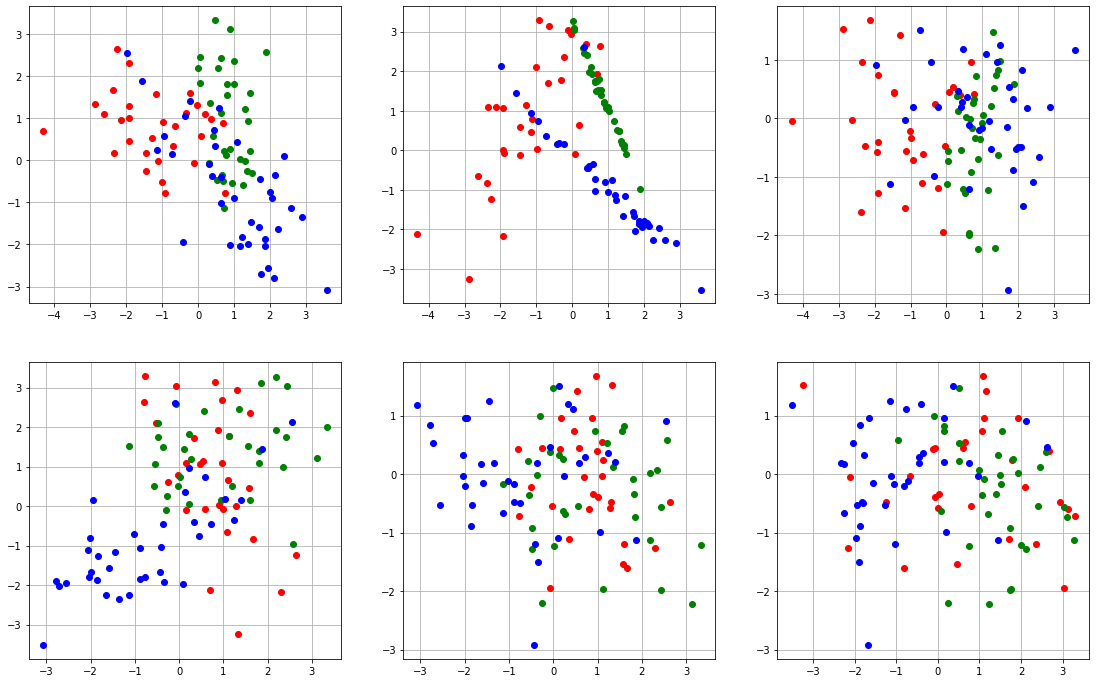

In [4]:
X, Y = make_classification(n_samples=150, n_features=4, 
                           n_informative=3, n_classes=3, 
                           n_redundant=0,
                           n_clusters_per_class=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=50)

fig, gs = plt.figure(figsize=(19, 12)), gridspec.GridSpec(2, 3)

ax = []
for i in range(6):
    ax.append(fig.add_subplot(gs[i]))

ax[0].plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 1], 'ro')
ax[0].plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 1], 'go')
ax[0].plot(X_train[np.where(Y_train==2), 0], X_train[np.where(Y_train==2), 1], 'bo')
ax[0].grid()

ax[1].plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 2], 'ro')
ax[1].plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 2], 'go')
ax[1].plot(X_train[np.where(Y_train==2), 0], X_train[np.where(Y_train==2), 2], 'bo')
ax[1].grid()

ax[2].plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 3], 'ro')
ax[2].plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 3], 'go')
ax[2].plot(X_train[np.where(Y_train==2), 0], X_train[np.where(Y_train==2), 3], 'bo')
ax[2].grid()

ax[3].plot(X_train[np.where(Y_train==0), 1], X_train[np.where(Y_train==0), 2], 'ro')
ax[3].plot(X_train[np.where(Y_train==1), 1], X_train[np.where(Y_train==1), 2], 'go')
ax[3].plot(X_train[np.where(Y_train==2), 1], X_train[np.where(Y_train==2), 2], 'bo')
ax[3].grid()

ax[4].plot(X_train[np.where(Y_train==0), 1], X_train[np.where(Y_train==0), 3], 'ro')
ax[4].plot(X_train[np.where(Y_train==1), 1], X_train[np.where(Y_train==1), 3], 'go')
ax[4].plot(X_train[np.where(Y_train==2), 1], X_train[np.where(Y_train==2), 3], 'bo')
ax[4].grid()

ax[5].plot(X_train[np.where(Y_train==0), 2], X_train[np.where(Y_train==0), 3], 'ro')
ax[5].plot(X_train[np.where(Y_train==1), 2], X_train[np.where(Y_train==1), 3], 'go')
ax[5].plot(X_train[np.where(Y_train==2), 2], X_train[np.where(Y_train==2), 3], 'bo')
ax[5].grid()

plt.show()

In [5]:
def entropy_np(Y_test):
    e = 0
    _, counts = np.unique(Y_test, return_counts = True)
    for c in counts:
        e += -c/Y_test.shape[0]*math.log(c/Y_test.shape[0], 2)
    return e

In [6]:
def gain_np(Y_test_before, Y_test_list_after):
    new_e = 0
    for y in Y_test_list_after:
        new_e += entropy_np(y)
    return entropy_np(Y_test_before) - new_e

In [7]:
def create_node_np(X_train, Y_train, features = None, min_gain = 1e-16, level = 0, orient = 'Root', debug = False):
    level = level + 1
    max_gain = 0
    best_feature = None
    best_feature_val = None
    
    if features is None:
        features = range(X_train.shape[1])
        
    for feature in features:
        if debug: print("working with feature", feature)
        for val in np.sort(X_train[:, feature]):
            Y_train_left = Y_train[np.where(X_train[:, feature] <= val)]
            Y_train_right = Y_train[np.where(X_train[:, feature] > val)]
            g = gain_np(Y_train, [Y_train_left, Y_train_right])
            if g > max_gain:
                max_gain = g
                best_feature = feature
                best_feature_val = val
    tab = '--' * level
    if max_gain <= min_gain:
        if debug: print(f"{tab} level_{level} {orient} max_gain = {max_gain}. Creating leaf node with value", stats.mode(Y_train).mode[0])
        return Node(value = stats.mode(Y_train).mode[0])

    order_left = np.where(X_train[:, best_feature] <= best_feature_val)
    order_right = np.where(X_train[:, best_feature] > best_feature_val)
    X_train_left = X_train[order_left]
    X_train_right = X_train[order_right]
    Y_train_left = Y_train[order_left]
    Y_train_right = Y_train[order_right]

    if debug: print(f"{tab} level_{level} {orient} Creating tree node with feature \"{best_feature}\", feature_val = {best_feature_val}, gain = {max_gain}")
    return Node(left = create_node_np(X_train_left, Y_train_left, level = level, orient = 'Left', debug = debug), 
                right = create_node_np(X_train_right, Y_train_right, level = level, orient = 'Right', debug = debug), 
                feature = best_feature, feature_val = best_feature_val)

In [8]:
class RF_C_np:
    
    def __init__(self, X_train, Y_train, min_gain = 1e-16, T = 10, l = 0.75, debug = False):
        self.X_train = X_train
        self.Y_train = Y_train
        self.min_gain = min_gain
        self.rf = None
        self.T = T
        self.l = l
        self.debug = debug
        
    def fit(self):
        self.rf = []
        t = 0
        attempt = 0
        while t < self.T:
            bag_x, oob_x, bag_y, oob_y = train_test_split(self.X_train, self.Y_train, test_size= math.ceil(self.Y_train.shape[0]*(1 - self.l)))
            k = np.sort(np.random.choice(np.arange(self.X_train.shape[1]), size = math.ceil(math.sqrt(self.X_train.shape[1])), replace = False))
            if self.debug: print("building tree from features", k)
            tree = create_node_np(bag_x, bag_y, features = k, min_gain = self.min_gain, debug = self.debug)
            accuracy = (np.where(np.array([DT(tree, x) for x in oob_x]) == oob_y)[0].shape[0])/oob_y.shape[0]
            if accuracy > 0:
                if self.debug: print(f"building tree {t}")
                self.rf.append(tree)
                t += 1
        
    def predict(self, X_test):
        Y_hat = []
        for x in X_test:
            prediction = [DT(tree, x) for tree in self.rf]
            Y_hat.append(stats.mode(prediction).mode[0])
        return np.array(Y_hat)

In [9]:
singletree = create_node_np(X_train, Y_train, debug = False)

In [10]:
Y_test.shape[0] - np.where(np.array([DT(singletree, x) for x in X_test]) == Y_test)[0].shape[0]

34

In [11]:
my_cls_sqrt = RF_C_np(X_train, Y_train, T = 100, l = 0.7, debug = False)

In [12]:
my_cls_sqrt.fit()

In [13]:
Y_test.shape[0] - np.where(my_cls_sqrt.predict(X_test) == Y_test)[0].shape[0]

11

In [14]:
sk_RF_sqrt = RandomForestClassifier(n_estimators = 100, criterion = "entropy", oob_score = True)

In [15]:
sk_RF_sqrt.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', oob_score=True)

In [16]:
Y_test.shape[0] - np.where(sk_RF_sqrt.predict(X_test) == Y_test)[0].shape[0]

13

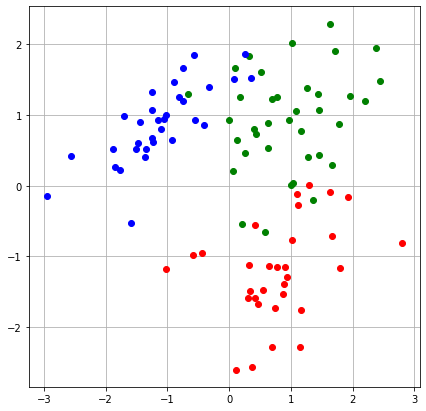

In [17]:
X, Y = make_classification(n_samples=150, n_features=2, 
                           n_informative=2, n_classes=3, 
                           n_redundant=0,
                           n_clusters_per_class=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=50)

fig = plt.figure(figsize=(7, 7))

plt.plot(X_train[np.where(Y_train==0), 0], X_train[np.where(Y_train==0), 1], 'ro')
plt.plot(X_train[np.where(Y_train==1), 0], X_train[np.where(Y_train==1), 1], 'go')
plt.plot(X_train[np.where(Y_train==2), 0], X_train[np.where(Y_train==2), 1], 'bo')
plt.grid()

plt.show()

In [18]:
my_cls_sqrt = RF_C_np(X_train, Y_train, T = 100, l = 0.7, debug = False)
my_cls_sqrt.fit()
sk_RF_sqrt = RandomForestClassifier(n_estimators = 100, criterion = "entropy", oob_score = True)
sk_RF_sqrt.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', oob_score=True)

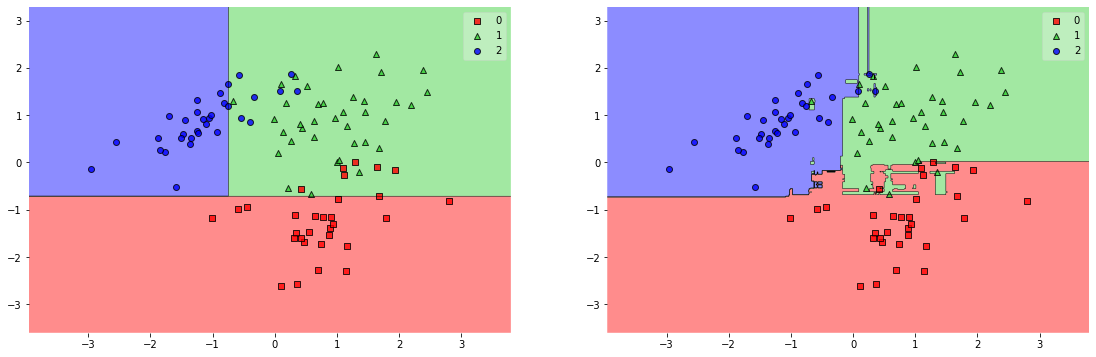

In [19]:
from mlxtend.plotting import plot_decision_regions
fig, gs = plt.figure(figsize=(19, 6)), gridspec.GridSpec(1, 2)

ax = []
for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    
plot_decision_regions(X_train, Y_train, my_cls_sqrt, ax=ax[0], colors = 'red,limegreen,blue,gray,cyan')
plot_decision_regions(X_train, Y_train, sk_RF_sqrt, ax=ax[1], colors = 'red,limegreen,blue,gray,cyan')

plt.show()

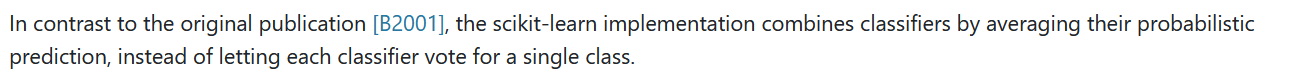

In [ ]:
class Node_p:
    def __init__(self, left = None, right = None, value = None, probability = 0, feature = None, feature_val = None):
        self.__left = left
        self.__right = right
        self.__feature = feature
        self.__value = value
        self.__feature_val = feature_val
        self.__probability = probability
        
    @property
    def right(self):
        return self.__right
    
    @right.setter
    def right(self, right):
        if isinstance(right, Node):
            self.__right = right
        else:
            print("self.__right can only be an instance of Node")
            
    @property
    def left(self):
        return self.__left
    
    @left.setter
    def left(self, left):
        if isinstance(left, Node):
            self.__left = left
        else:
            print("self.__left can only be an instance of Node")
            
    @property
    def value(self):
        return self.__value
    
    @value.setter
    def value(self, value):
        allowed_values = ["Iris-setosa", "Iris-versicolor", "Iris-virginica"]
        if value in allowed_values:
            self.__value = value
        else:
            print("self.__value can only be one of", allowed_values)
    
    @property
    def feature(self):
        return self.__feature
    
    @property
    def feature_val(self):
        return self.__feature_val
    
    @property
    def probability(self):
        return self.__probability